In [50]:
%pip install  scikit-learn pd numpy nltk

Note: you may need to restart the kernel to use updated packages.


In [ ]:
'''
Tiền xử lý dữ liệu
Biến đỗi các từ trong tập dữ liệu DUC sang CSV để tiện xử lý. ở các bước tiếp theo
'''
import os
import pandas as pd
import re

def parse_sentence(line):
        match = re.match(r'<s docid="([^"]+)" num="(\d+)" wdcount="(\d+)"> (.*)</s>', line)
        if match:
            return {
                'docid': match.group(1),
                'num': int(match.group(2)),
                'wdcount': int(match.group(3)),
                'sentence': match.group(4)
            }
        return None
    
def convert_duc_to_csv(input_dir = './DUC_TEXT/train', out_dir='DUC_TEST_sentences.csv'):
    '''
    Duyệt tất các file trong thư mục data - sau đó parse senctence.
    Dữ liệu sẽ được lưu vào DataFrame và xuất ra file CSV.
    '''
    data = []
    for filename in os.listdir(input_dir):
        file_path = os.path.join(input_dir, filename)
        if os.path.isfile(file_path):
            with open(file_path, 'r', encoding='utf-8') as f:
                for line in f:
                    line = line.strip()
                    if line.startswith('<s docid='):
                        parsed = parse_sentence(line)
                        if parsed:
                            data.append(parsed)

    df = pd.DataFrame(data)
    df.to_csv(out_dir, index=False)

convert_duc_to_csv()

# Build graph from word cloud
1. Method 1: Use frequency 
2. Method 2: Use vector similarity 

In [ ]:

import numpy as np
import pandas as pd

def compute_tfidf(sentences):
  '''
  Trong ham nay pham vi bieu dien   
  '''
  # Dict chứa key ({lowercase of word: so luong tu })
  vocab = {}
  for sent in sentences:
    for word in sent.lower().split():
      vocab[word] = vocab.get(word, 0) + 1
  
  # Chuyen tat ca tu da tinh toan trong dict - thanh list de chuyen 
  # Danh index - vị trí của từ trong toàn bộ văn bản.
  # Lay tap ho cac key cua tu dien
  terms = list(vocab.keys())
  term_index = {term: idx for idx, term in enumerate(terms)}

  print(term_index)
  # Calculate frequency
  tf = np.zeros((len(sentences), len(terms)))

  '''
    Input:
    sentences: ["Xin chao ban", "Minh ten la Kha"]
    term_index: {'xin': 0, 'chao': 1, 'ban': 2, 'minh': 3, 'ten': 4, 'la': 5, 'kha': 6}
    Step:
       1. Duyệt từ đoạn văn bản sentences
       2. Chuyển thành lower sau đó tách theo khoản trắng thanh các từ đơn.
       3. Duyệt từng từ & duyệt items trong term index để complete ma trận tf
       4. tf[sentence thứi,vị trí tại các từ có value] += 1 
  '''
  
  for i, sent in enumerate(sentences):
    words = sent.lower().split()
    for word in words:
      if word in term_index:
        tf[i, term_index[word]] += 1

    tf[i] /= len(words)
  # Compute document frequency (DF)
  df_counts = np.zeros(len(terms))

  for idx, term in enumerate(terms):
    df_counts[idx] = sum(term in sent.lower().split() for sent in sentences)
  
  # Compute IDF
  N = len(sentences)
  idf = np.log((N + 1) / (df_counts + 1)) + 1
  
  # Compute TF-IDF
  tfidf = tf * idf
  
  tfidf_df = pd.DataFrame(tfidf, columns=terms)
  return tfidf_df

def cosine_sim_matrix(X):
  X_norm = X / np.linalg.norm(X, axis=1, keepdims=True)
  return np.dot(X_norm, X_norm.T)

def euclidean_dist_matrix(X):
  return np.linalg.norm(X[:, np.newaxis] - X[np.newaxis, :], axis=-1)

In [66]:
sentence = "Xin chao ban, minh la ban cua ban, minh ten la kha"
sentecne_1 = "Hello ban, minh ten la kha"
tf_idf =  compute_tfidf([sentence, sentecne_1])

{'xin': 0, 'chao': 1, 'ban,': 2, 'minh': 3, 'la': 4, 'ban': 5, 'cua': 6, 'ten': 7, 'kha': 8, 'hello': 9}


In [ ]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
  # Lowercase
  text = text.lower()
  # Remove punctuation
  text = text.translate(str.maketrans('', '', string.punctuation))
  # Remove digits
  text = re.sub(r'\d+', '', text)
  # Remove extra whitespace
  text = re.sub(r'\s+', ' ', text).strip()
  # Remove stopwords and lemmatize
  text = ' '.join(
    lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words
  )
  return text

[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/vscode/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# data loader
def read_sentences(file_path ='DUC_TEST_sentences.csv'):
    df = pd.read_csv(file_path)
    return df

def save_df(df, file_path='DUC_TEST_weight.csv'):
    df.to_csv(file_path, index=False)


# Preprocessing data

In [ ]:
# Clearn text
def clean_text(df):
    df['sentence'] = df['sentence'].apply(preprocess_text)
    return df
  

In [ ]:

'''
1. Tien xu ly van ban truoc khi day tinh toan tuong dong gia cac doan van trong doc
2. Nhom tat ca item trong document theo docid de tinh toan tuong dong cua cac cau van trong document
3. Duyệt từng câu văn trong docs id:
   - Tinh tf-idf
   - Tinh toan cosine similarity giua cac cau van trong doan van
4. Lưu gia tri tinh toan duoc vao data frame.
   - Duyet tung item trong ma tran viua tim duoc luu vao df để khỏi tính lại ở các bước sau.
'''
df = read_sentences('DUC_TEST_sentences.csv')
df = df.head(10)
df = clean_text(df)
grouped = df.groupby('docid')
edges = []

for docid, group in grouped:
  sentences = group['sentence'].tolist()
  indices = group['num'].tolist()
  
  X = compute_tfidf(sentences).values
  sim_matrix = cosine_sim_matrix(X)
  
  n = len(sentences)
  
  for i in range(n):
    for j in range(n):
      weight = sim_matrix[i, j]
      edges.append({'docid': docid, 'src': indices[i], 'dst': indices[j], 'weight': weight})
edges_df = pd.DataFrame(edges)
save_df(edges_df)


/tmp/ipykernel_1293/4289590058.py:20: RuntimeWarning: invalid value encountered in divide
  tf[i] /= len(words)


In [ ]:
'''
  Muc tieu cua doan nay: 
  - Chuyen toi de qua tinh toan o bước trước thành ma trận kề 
  - Với tiêu chí độ tương đồng giửa 2 vector là nhỏ hơn ngưỡng SIM_THRESHOLD nghĩa là nó tương tuồng nhau vào có liên hệ giữa 2 câu văn.
  - Trong bài này em đã thử gán giá trị tại các đỉnh nếu có kết nối là giá trị tính toán tương đồng luôn thay vì gán là 1,
  - Kết quả thực nghiệm được so sánh bên dưới,
  - Cuoi cung luu ket qua tinh toan vào file json để không phải tính lại 
'''
SIM_THRESHOLD = 0.21
import json

adj_matrices = []
for docid, group in edges_df.groupby('docid'):
  indices = sorted(group['src'].unique())
  n = len(indices)
  
  adj_matrix = np.zeros((n, n))
  
  idx_map = {idx: i for i, idx in enumerate(indices)}
  
  for _, row in group.iterrows():
    i = idx_map[row['src']]
    j = idx_map[row['dst']]
    similarity = row['weight']
    
    if i == j:
      adj_matrix[i, j] = 0
      
    elif similarity < SIM_THRESHOLD:
      adj_matrix[i, j] = 1
    
    else:
      adj_matrix[i, j] = 0
  
  adj_matrices.append(adj_matrix.tolist())

with open('adj_matrices.json', 'w') as f:
  json.dump(adj_matrices, f)


# Algorithm: PageRank for Undirected Graph
1. Chuyen matran thanh matran kieu numpy de thuc hien cac buoc tinh toan de dang hon như shape, sum,....
2. Tim bac cua tung node.
4. Luu y:
- Co mot so cong thuc no dung ma tran chuyen vi graph.T may cai do dung cho do thi co huong thoi:
  + Vi sao?
5. Tai sao?
  - numpy.dot? Thay vi loop de kiem tra dieu kien - dinh co lien ket voi dinh khac de tinh pr - khi ham nay se nhan 2 ma tran lai voi nhau - cai nao co chi so (1) thi co value, cai nao khogn co chi so (0) thi khong co value
  - dot([[0, 1, 0],[1, 0, 1],[0, 1, 0]], [[0, 1/2, 0],[1/3, 0, 1/2],[0, 1/2, 0]])
  

In [ ]:
'''
  Phần này là tính toan PageRank cho ma trận kề đã tạo ở bước trước.
  - Sử dụng ma trận kề đã tạo để tính toan PageRank.
  - Kết quả là ma trận PageRank cho từng node trong ma trận kề.
  - Test voi vi du cua cô trên lớp.
'''

def pagerank(undirected_graph, damping_factor=0.85, max_loop=100, delta=1e-10):
  import numpy 
  undirected_graph = numpy.array(undirected_graph, dtype=float)

  total_node = undirected_graph.shape[0]
  degree_of_node = undirected_graph.sum(axis=1)
  
  base_matrix = numpy.ones(total_node)
  # [[1,1,1,1]]
  degree_of_node[degree_of_node == 0] = 1  # Avoid division by zero
  
  for _ in range(max_loop):
    new_page_rank_matrix = damping_factor * numpy.dot(undirected_graph, base_matrix/degree_of_node) + (1 - damping_factor) / total_node
    if sum(abs(new_page_rank_matrix - base_matrix)) < delta:
      break
    base_matrix = new_page_rank_matrix

  return base_matrix

# data =[
#   [0, 1, 1, 1, 1, 0],
#   [1, 0, 1, 1, 1, 0],
#   [1, 1, 0, 1, 0, 0],
#   [1, 1, 1, 0, 0, 1],
#   [1, 1, 0, 0, 0, 1],
#   [0, 0, 0, 1, 1, 0]
# ]

# pg = pagerank(data)
# pg

In [ ]:
'''
- Phan nay doc lai ma tran ke đã tính ở bước trước
- Chuyển nó thành np array cho cho dể tính toán
'''
# read from data
def read_adj_matrices(file_path='adj_matrices.json'):
  with open(file_path, 'r') as f:
    adj_matrices = json.load(f)
    # convert to numpy arrays
    adj_matrices = [np.array(matrix) for matrix in adj_matrices]
  return adj_matrices


In [ ]:
# Calculate the weight of each edge
'''
Duyệt từng ma trân (mỗi văn bản) để tính pagerank.
'''
def caculate_page_range(adj_matrices):
    page_ranks = []
    for adj_matrix in adj_matrices:
        pr_scores = pagerank(np.array(adj_matrix))
        page_ranks.append(pr_scores)
    return page_ranks

In [ ]:
'''
  Sau khi đã chuẩn bị các hàm ở bước trên thì gọi ra và sử dụng để tính toán pagrrange.
'''
matrices = read_adj_matrices('adj_matrices.json')
page_ranks = caculate_page_range(matrices)

In [ ]:
'''
    Sau khi tính xong rồi thì chuyển qua bước tóm nội dung:
    Bước 1: Duyệt lại dữ liệu gốc để lấy docid
    Bước 2: Group lại ds kết quả & danh sách kết quả page_rank (Khâu này có thể dẫn đến lệch id) làm các bước sau sai theo 
    Bước 3: Lấy ra văn bản tóm tắt 
        - Xếp lại điểm pagge rank theo thứ tự giảm dần từ trên xuống dưới.
        - Chổ này muốn lấy tom bao nhiêu phụ thuộc vào n_top bằng 36 phần trăm của câu gốc:
    Bước 4: Ứng với top kết quả tìm được map với docs id để ra văn văn bản gốc đã được tóm tắt.
'''

def summarize_sentences_separate_rows(df, page_ranks, top_n=None):
    results = []
    docids = [docid for docid, _ in df.groupby('docid')]
    page_rank_map = dict(zip(docids, page_ranks))
    
    for docid, group in df.groupby('docid'):
        indices = group['num'].tolist()
        # Muc tieu cua ham nay la gi vay troi:
        # input: [{'docid': 'doc1', 'num': 1, 'sentence': 'This is a sentence.'}, ...]
        ranks = page_rank_map.get(docid, [0]*len(indices))

        rank_scores = dict(zip(indices, ranks))
        
        # 
        n_sent = len(indices)
        n_top = int(n_sent * 0.36) if top_n is None else top_n
        n_top = max(1, n_top)  # Ensure at least one sentence
        
        top_sentences = sorted(rank_scores.items(), key=lambda x: x[1], reverse=True)[:n_top]

        for num, score in top_sentences:
            sentence_row = group[group['num'] == num]['sentence']
            
            if not sentence_row.empty:
                results.append({'docid': docid, 'num': num, 'score': score, 'sentence': sentence_row.values[0]})
    
    return pd.DataFrame(results)

In [ ]:
'''
  Chổ này chỉ đơn giản là lưu kết quả tinhs vào file csv.
'''
summaries_df = summarize_sentences_separate_rows(df, page_ranks)
summaries_df.to_csv('DUC_TEST_summaries_separate.csv', index=False)
# summaries_df.head(n=20)


# Evaluate
1. Base of result use some metrix to evalue algorithm to optimize
2. Lam sao de doan tom tat tro len muot ma, tu nhien, luu loat

# Cach kiem tra ket qua nhan ve co bao nhieu cau khop voi dap an
1. Build the sum then convert with format same same with iniput


In [35]:
convert_duc_to_csv('./DUC_SUM/', out_dir='DUC_SUM_sentences.csv')

In [ ]:
'''
  Sau khi tính toán xong hết ôrồi, có kết quả rồi thì cần xác định được ososj chính xác để có bước điều chỉnh tiếp theo
  1. Mô tả công thức tính precision & recall:
  2. Duyệt lại kết quả đã tóm tắt so so với kết quả cô đưa
  3. Tính và lưu lại vào df để lát show ra biểu đò
  [TODO]: HIeu ro cong thuc tinh preciison & recall
'''
def calc_precision_recall_f1(correct, total_pred, total_ref):
  precision = correct / total_pred if total_pred > 0 else 0
  recall = correct / total_ref if total_ref > 0 else 0
  f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
  return precision, recall, f1

def evaluate_summary_accuracy(ref_file, calc_df):
  ref_df = pd.read_csv(ref_file)
  ref_docids = set(ref_df['docid'])
  calc_df = calc_df[calc_df['docid'].isin(ref_docids)]
  results = []
  for docid, group in calc_df.groupby('docid'):

    pred_nums = set(group['num'])
    ref_group = ref_df[ref_df['docid'] == docid]
    ref_nums = set(ref_group['num'])
    
    # Khúc này & là nó lấy nhwunxg phần tử chung ra. và lấy ra dược correct
    correct = len(pred_nums & ref_nums)
    total_pred = len(pred_nums) # Để lấy độ dài câu predict
    total_ref = len(ref_nums) # Để lấy độ dài câu gốc.
    
    precision, recall, f1 = calc_precision_recall_f1(correct, total_pred, total_ref)
    results.append({
      'docid': docid,
      'correct': correct,
      'total_pred': total_pred,
      'total_ref': total_ref,
      'precision': precision,
      'recall': recall,
      'f1': f1,
    })
  acc_df = pd.DataFrame(results)
  acc_df.to_csv('DUC_TEST_accuracy.csv', index=False)
  return acc_df


In [1]:

acc_df = evaluate_summary_accuracy('DUC_SUM_sentences.csv', summaries_df)
acc_df.head(n=20)

NameError: name 'evaluate_summary_accuracy' is not defined

In [ ]:
# Use Precicion & Recall to caculate accuracy 
# Then use F1 score to evaluate the accuracy

In [ ]:
# What is Precistion and Recall?


# Recall: The ratio of correctly predicted positive observations to the all observations in actual class.
1. P: So ket qua dung / so mo hinh trich xuat ra
2. R: So ket qua dung / cai chung ta ky vong.
3. F1: 2*(P*R)/(P+R)

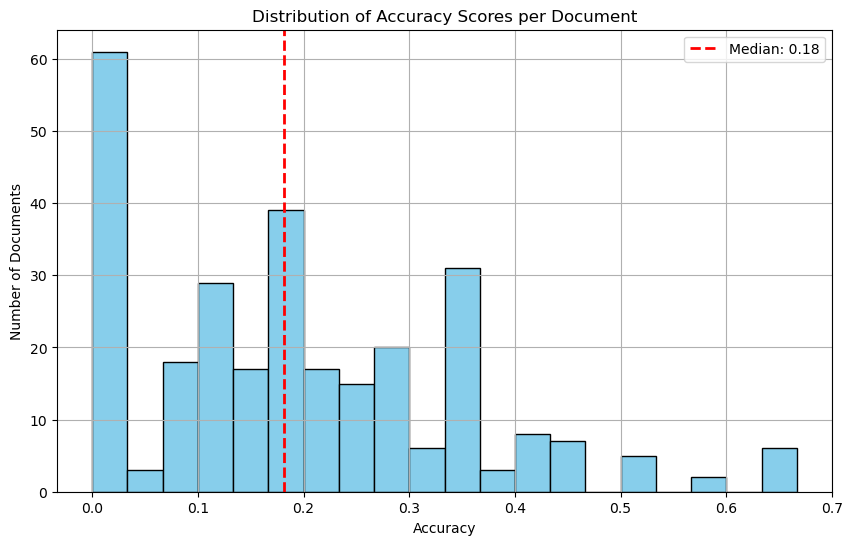

In [ ]:
'''
Bước này vẽ biểu đồ:
1. Mục tiêu của bước thể hiện được tổng quan accurracy & số lương document đạt accuracy ây
2. Đọc biểu đồ theo kiểu: Cố 20 câu đạt accurray là 0.2
3. Trung bình trên toàn bộ dữ liệu là 0.18
'''
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(acc_df['f1'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Accuracy')
plt.ylabel('Number of Documents')
plt.title('Distribution of Accuracy Scores per Document')

median_f1 = acc_df['f1'].median()

plt.axvline(median_f1, color='red', linestyle='dashed', linewidth=2, label=f'Median: {median_f1:.2f}')

plt.legend()
plt.grid(True)
plt.show()
